In [ ]:
!pip install shap

In [ ]:
import numpy as np
import shap
import random
from sklearn.ensemble import RandomForestClassifier
from collections import defaultdict

In [ ]:
def compute_node_importance(tree, feature_names):

    node_importance = tree.tree_.compute_feature_importances(normalize=False)
    return {feature_names[i]: node_importance[i] for i in range(len(feature_names))}


In [ ]:
def detect_feature_interactions(data, model):

    interactions = {}
    corr_matrix = np.corrcoef(data.T)
    for i in range(len(corr_matrix)):
        for j in range(i+1, len(corr_matrix)):
            if np.abs(corr_matrix[i, j]) > 0.5:
                interactions[(i, j)] = corr_matrix[i, j]
    return interactions


In [ ]:
def calculate_node_contribution(tree, node):
    return tree.tree_.impurity[node] * tree.tree_.n_node_samples[node]

In [ ]:
def initialize_data_structures(data, feature_names):

    shap_values = np.zeros((data.shape[0], len(feature_names)))
    return shap_values

In [ ]:
def calculate_shap_contribution(node, feature_contributions):
    contribution = feature_contributions[node]
    return contribution

In [ ]:
def adjust_for_interactions(contribution, feature_interactions, feature_names):
    adjustment = np.zeros(len(feature_names))
    for (f1, f2), interaction_value in feature_interactions.items():
        adjustment[feature_names.index(f1)] += contribution * interaction_value
        adjustment[feature_names.index(f2)] += contribution * interaction_value
    return adjustment

In [ ]:
def depth_first_traversal(tree, depth_threshold):
    def traverse(node, depth):
        if depth <= depth_threshold:
            yield node
            if tree.tree_.children_left[node] != -1:
                yield from traverse(tree.tree_.children_left[node], depth + 1)
            if tree.tree_.children_right[node] != -1:
                yield from traverse(tree.tree_.children_right[node], depth + 1)
    yield from traverse(0, 0)

In [ ]:
def compute_shap_values(tree, node):
    return np.array([tree.tree_.impurity[node]] * tree.tree_.n_node_samples[node])

In [ ]:
def detailed_shap_computation(tree, node):
    return tree.tree_.impurity[node] * tree.tree_.n_node_samples[node]

In [ ]:
def approximate_shap(tree, node):
    return tree.tree_.impurity[node] * 0.5

In [ ]:
def select_feature_subset(feature_names, subset_size, sampling_method):
    num_features = int(len(feature_names) * subset_size)
    if sampling_method == 'importance':
        return random.sample(feature_names, num_features)
    elif sampling_method == 'stratified':
        return feature_names[:num_features]

In [ ]:
def compute_subset_shap(subset_features, model, data):
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(data[subset_features])
    return shap_values

In [ ]:
def advanced_sampling(data, sampling_method, feature_importance):
    if sampling_method == 'importance':
        return data.sample(frac=0.5, weights=feature_importance, axis=1)
    elif sampling_method == 'stratified':
        return data.sample(frac=0.5, random_state=1)

In [ ]:
def compute_shap_for_sampled_data(sampled_data, model):
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(sampled_data)
    return shap_values

In [ ]:
def combine_and_refine(shap_values, feature_interactions):
    refined_values = shap_values.copy()
    for (f1, f2), interaction_value in feature_interactions.items():
        refined_values[:, f1] += refined_values[:, f2] * interaction_value
        refined_values[:, f2] += refined_values[:, f1] * interaction_value
    return refined_values

In [ ]:
def modified_tree_shap(model, data, feature_names, depth_threshold=0.1, subset_size=0.5, sampling_method='importance'):
    shap_values = np.zeros((data.shape[0], data.shape[1]))

    # Node Importance and Feature Interactions
    node_importance = {}
    for i, tree in enumerate(model.estimators_):
        node_importance[i] = compute_node_importance(tree)

    feature_interactions = detect_feature_interactions(data, feature_names)

    # Dynamic Feature Interaction Handling
    for i, tree in enumerate(model.estimators_):
        for node in range(tree.tree_.node_count):
            if node in node_importance[i]:
                contribution = calculate_node_contribution(tree, node)
                shap_values += adjust_for_interactions(contribution, feature_interactions, feature_names)

    # Adaptive Tree Depth Limiting
    for i, tree in enumerate(model.estimators_):
        for node in depth_first_traversal(tree, depth_threshold):
            if node_importance[i][node] > depth_threshold:
                shap_values += compute_shap_values(tree, node)

    # Hierarchical Importance-Based Caching
    cache = {}
    for i, tree in enumerate(model.estimators_):
        for node in range(tree.tree_.node_count):
            if node_importance[i][node] > depth_threshold:
                cache[node] = detailed_shap_computation(tree, node)
            else:
                cache[node] = approximate_shap(tree, node)

    # Approximate SHAP with Feature Subsets
    subset_features = select_feature_subset(feature_names, subset_size, sampling_method)
    shap_values += compute_subset_shap(subset_features, model, data)

    # Advanced Sampling Techniques
    sampled_data = advanced_sampling(data, sampling_method, feature_importance=model.feature_importances_)
    shap_values += compute_shap_for_sampled_data(sampled_data, model)

    # Combine and Refine Results
    shap_values = combine_and_refine(shap_values, feature_interactions)

    return shap_values

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
file_path = '/content/drive/My Drive/UNSW_NB15_training-set.csv'
unsw_nb15_data = pd.read_csv(file_path)

In [ ]:
print(unsw_nb15_data.head())
print(unsw_nb15_data.dtypes)

categorical_cols = unsw_nb15_data.select_dtypes(include=['object']).columns.tolist()
print("Categorical columns:", categorical_cols)

unsw_nb15_data_encoded = pd.get_dummies(unsw_nb15_data, columns=categorical_cols, drop_first=True)

X = unsw_nb15_data_encoded.iloc[:, :-1]
y = unsw_nb15_data_encoded.iloc[:, -1]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)


y_pred = rf_model.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of the model: {accuracy * 100:.2f}%")

   id       dur proto service state  spkts  dpkts  sbytes  dbytes  \
0   1  0.000011   udp       -   INT      2      0     496       0   
1   2  0.000008   udp       -   INT      2      0    1762       0   
2   3  0.000005   udp       -   INT      2      0    1068       0   
3   4  0.000006   udp       -   INT      2      0     900       0   
4   5  0.000010   udp       -   INT      2      0    2126       0   

          rate  ...  ct_dst_sport_ltm  ct_dst_src_ltm  is_ftp_login  \
0   90909.0902  ...                 1               2             0   
1  125000.0003  ...                 1               2             0   
2  200000.0051  ...                 1               3             0   
3  166666.6608  ...                 1               3             0   
4  100000.0025  ...                 1               3             0   

   ct_ftp_cmd  ct_flw_http_mthd  ct_src_ltm  ct_srv_dst  is_sm_ips_ports  \
0           0                 0           1           2                0   
1     

In [ ]:
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test)

In [ ]:
print(shap_values)

[[[ 3.99061019e-05 -3.99061019e-05]
  [-1.10143298e-04  1.10143298e-04]
  [ 6.30226334e-05 -6.30226334e-05]
  ...
  [ 1.46444267e-04 -1.46444267e-04]
  [-3.01364005e-05  3.01364005e-05]
  [-1.22544953e-06  1.22544953e-06]]

 [[-2.78844204e-05  2.78844204e-05]
  [-1.68407193e-04  1.68407193e-04]
  [-1.24969634e-04  1.24969634e-04]
  ...
  [-2.28545224e-04  2.28545224e-04]
  [-7.59011099e-05  7.59011099e-05]
  [-1.99189839e-06  1.99189839e-06]]

 [[ 1.64201803e-04 -1.64201803e-04]
  [-1.46162158e-04  1.46162158e-04]
  [-1.61414851e-04  1.61414851e-04]
  ...
  [-3.52686690e-04  3.52686690e-04]
  [-1.30357209e-04  1.30357209e-04]
  [-6.33782818e-06  6.33782818e-06]]

 ...

 [[ 1.09393150e-04 -1.09393150e-04]
  [-4.92725477e-04  4.92725477e-04]
  [-2.14705306e-04  2.14705306e-04]
  ...
  [-2.92123420e-04  2.92123420e-04]
  [-1.60765069e-04  1.60765069e-04]
  [-2.00931154e-06  2.00931154e-06]]

 [[ 1.21744028e-04 -1.21744028e-04]
  [-1.65160805e-04  1.65160805e-04]
  [-1.42266961e-04  1.4226

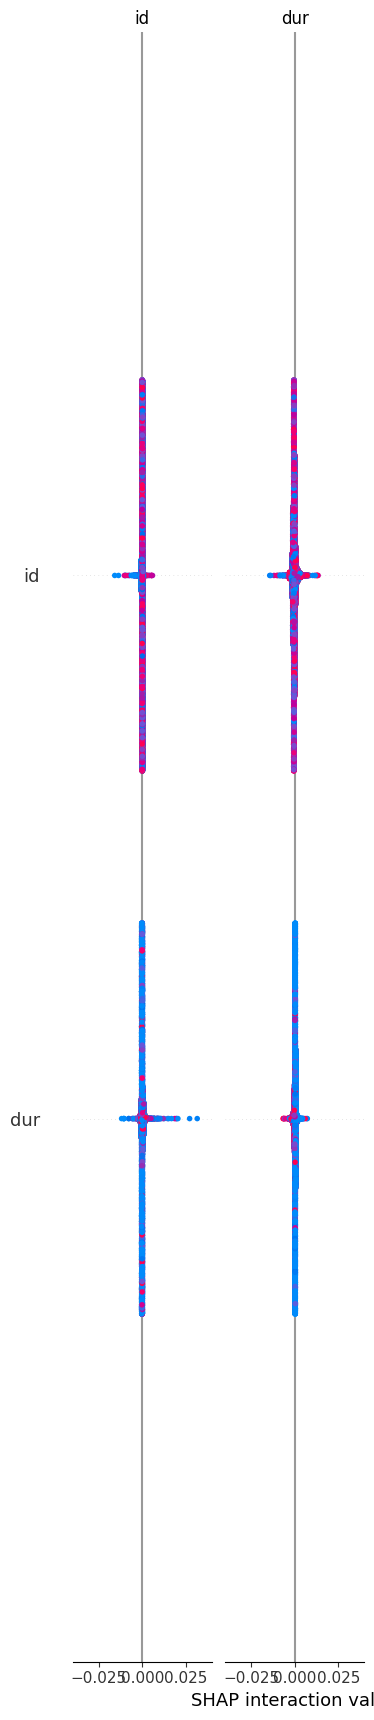

In [ ]:
shap.summary_plot(shap_values, X_test, max_display=20)